<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/estudo-dados-eleicoes/blob/master/mapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import folium
import requests
import pandas as pd
import numpy as np

In [60]:
url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/brazil-states.geojson'
data = requests.get(url).json()["features"]
len(data)

27

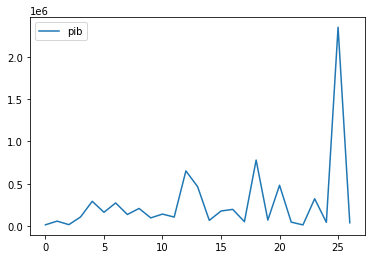

In [65]:
url = 'https://www.ibge.gov.br/explica/pib.php'
df = pd.read_html(url , match='Unidades da Federação')[0]
ints = list(map(lambda x:int(x.replace('.','')),df['PIB em 2019 (1.000.000 R$)']))
realDf = pd.DataFrame(np.c_[df['Unidades da Federação'], ints], columns=['state', 'pib'])
realDf

In [63]:
mapa = folium.Map(location=[48, -102], zoom_start=3)

mapa.choropleth(geo_data=json.load(data), data=realDf,
                columns=['state','pib'],
                key_on='feature.id',  # Check your GeoJSON for the name!
                fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
                legend_name='Ucoold')

mapa

AttributeError: ignored